In [1]:
from skfem import *
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov, solver_eigen_scipy, solver_iter_pcg
from skfem.helpers import dd, ddot, div, grad
from scipy.sparse.linalg import LinearOperator, minres
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import bmat
import dmsh
from skfem.assembly import BilinearForm, LinearForm
plt.rcParams['figure.dpi'] = 100

## Begin equation

$$
- \nu\Delta\boldsymbol{u} + \rho^{-1}\nabla p = \boldsymbol{f} \ in \  \Omega
$$

$$
\nabla\cdot\boldsymbol{u} = 0 \ in \  \Omega
$$

$$
u = 0 \ on \ \partial \Omega
$$

`u` is the velocity vector and `p` is the pressure

`basis.find_dofs()` almost equals to `m.boundary_nodes()`

$$
\left(\begin{array}{cc}
A & -B \\
B^{T} & 0
\end{array}\right)\left(\begin{array}{l}
U \\
P
\end{array}\right)=\left(\begin{array}{l}
F_{1} \\
0
\end{array}\right)
$$

## $(P_2,P_1)$ Taylor-Hood element: Optimal convergent rate

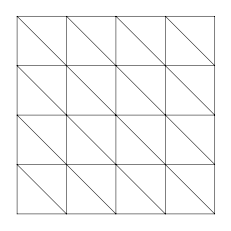

In [116]:
# mesh = MeshTri(*map(np.transpose, dmsh.generate(dmsh.Circle([0., 0.], 1.), .7))) 

mesh = MeshTri()
mesh.refine(2)

element = {'u': ElementVectorH1(ElementTriP2()),
           'p': ElementTriP1()}
basis = {variable: InteriorBasis(mesh, e, intorder=4) 
         for variable, e in element.items()} # intorder: integration order for quadrature

draw(mesh)

In [117]:
@BilinearForm
def vector_laplace(u, v, w):
    '''
    a
    '''
    return ddot(grad(u), grad(v))


@BilinearForm
def divergence(u, v, w):
    '''
    b
    '''
    return div(u) * v


@LinearForm
def body_force(v, w):
    '''
    for f
    '''
    x, y = w.x
    f1 = 120*(x**2-x)*y*(y-1)*(2*y-1)+10*x**2*(x-1)**2*(12*y-6)+2*x
    f2 = -(120*(y**2-y)*x*(x-1)*(2*x-1)+10*y**2*(y-1)**2*(12*x-6))-2*y
    
    return f1 * v.value[0] + f2*v.value[1]


@BilinearForm
def mass(u, v, w):
    return u * v

In [134]:
A = asm(vector_laplace, basis['u'])
B = asm(divergence, basis['u'], basis['p'])
C = asm(mass, basis['p'])

K = bmat([[A, -B.T],
          [-B, 1e-7 * C]], 'csr') # get the sparse format of the result by 'csr'
f = np.concatenate([asm(body_force, basis['u']),
                    np.zeros(B.shape[0])])

In [135]:
%%time
up = solve(*condense(K, f, D=basis['u'].find_dofs()), solver=solver_iter_pcg())

Wall time: 4.71 ms


In [136]:
u, p = np.split(up, [A.shape[0]])
U = basis['u'].interpolate(u)

# uh = U.value
# uh.shape
# x = basis['u'].global_coordinates().value
# x.shape

## Error estimating

In [140]:
def exactu(x, y):
    u1 = 10*x**2*(x-1)**2*y*(y-1)*(2*y-1)
    u2 = -10*y**2*(y-1)**2*x*(x-1)*(2*x-1)
    return u1, u2

@Functional
def L2Error_u(w):
    x, y = w.x
    u1, u2 = exactu(x, y)
#     print((w.w[0] - u1)**2)
#     print((w.w[1] - u2)**2)
    return (w.w[0] - u1)**2 + (w.w[1] - u2)**2

In [141]:
mesh = MeshTri()
mesh.refine(3)

element = {'u': ElementVectorH1(ElementTriP2()),
           'p': ElementTriP1()}
basis = {variable: InteriorBasis(mesh, e, intorder=4) 
         for variable, e in element.items()} # intorder: integration order for quadrature

A = asm(vector_laplace, basis['u'])
B = asm(divergence, basis['u'], basis['p'])
C = asm(mass, basis['p'])

K = bmat([[A, -B.T],
          [-B, 1e-6 * C]], 'csr') # get the sparse format of the result by 'csr'
f = np.concatenate([asm(body_force, basis['u']),
                    np.zeros(B.shape[0])])

up = solve(*condense(K, f, D=basis['u'].find_dofs()), solver=solver_iter_pcg())

u, p = np.split(up, [A.shape[0]])

U = basis['u'].interpolate(u)
L2u = np.sqrt(L2Error_u.assemble(basis['u'], w=U))

print('L2 Error:', L2u)

L2 Error: 0.10830642362517717


### Analysising

In [ ]:
K

In [ ]:
A.shape

In [ ]:
B.shape

In [ ]:
C.todense() # sparse to dense

## Solving the stream function $\psi$
from $$-\Delta \psi=\operatorname{rot} \boldsymbol{u}$$

In [ ]:
# @LinearForm
# def rot(v, w):
#     return np.einsum('i...,ij...,j...',
#                      w.w, np.array([[0, 1], [-1, 0]]), grad(v)

In [ ]:
# basis['psi'] = InteriorBasis(mesh, ElementTriP2())
# A = asm(laplace, basis['psi'])

# vorticity = asm(rot, basis['psi'], w=[basis['psi'].interpolate(velocity[i::2]) for i in range(2)])
# psi = solve(*condense(A, vorticity, D=basis['psi'].find_dofs()), solver=solver_iter_pcg())

## Visualization

In [ ]:
# from matplotlib.tri import Triangulation
# from skfem.visuals.matplotlib import plot, draw

# print(basis['psi'].interpolator(psi)(np.zeros((2, 1)))[0],
#       '(cf. exact 1/64)')

# print(basis['p'].interpolator(pressure)(np.array([[-0.5, 0.5],
#                                                   [0.5, 0.5]])),
#       '(cf. exact -/+ 1/8)')

# ax = draw(mesh)
# plot(basis['p'], pressure, ax=ax, colarbar = True)

# ax = draw(mesh)
# velocity1 = velocity[basis['u'].nodal_dofs]
# ax.quiver(*mesh.p, *velocity1, mesh.p[0, :])  # colour by buoyancy

# ax = draw(mesh)
# ax.tricontour(Triangulation(*mesh.p, mesh.t.T),
#               psi[basis['psi'].nodal_dofs.flatten()])

## Trying $(P_1,P_0)$ 

In [2]:
# mesh = MeshTri.init_circle(1)

# element = {'u': ElementVectorH1(ElementTriP1()),
#            'p': ElementTriP0()}
# basis = {variable: InteriorBasis(mesh, e, intorder=3) 
#          for variable, e in element.items()} # intorder: integration order for quadrature

# basis['psi'] = InteriorBasis(mesh, ElementTriP1())